In [2]:
import torch
import torchvision as tv
import torch.nn as nn
import copy
import numpy as np

In [3]:
train_data = tv.datasets.FashionMNIST(root='data',train=True,download=True)
test_data = tv.datasets.FashionMNIST(root='data',train=False,download=True)

In [4]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
labels = copy.deepcopy(train_data.targets)
labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
images = train_data.data.view([60000,1,28,28]).float()

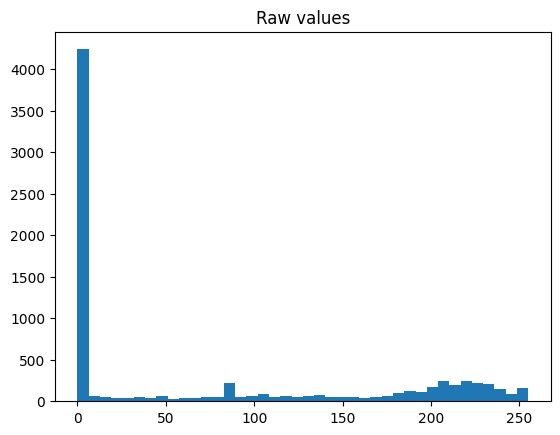

In [8]:
import matplotlib.pyplot as plt
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title("Raw values")
plt.show()
images = images/256

In [9]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size=0.2)
train_data = torch.utils.data.TensorDataset(x_train,y_train)
test_data = torch.utils.data.TensorDataset(x_test,y_test)

num_batches = 100
train_loader = torch.utils.data.DataLoader(train_data,batch_size=num_batches,shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=num_batches,shuffle=True,drop_last=True)

In [10]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([48000, 1, 28, 28])
torch.Size([48000])


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        #img_shape = (14,14), num_channels = 16

        self.conv2 = nn.Conv2d(16,16,kernel_size=5,padding=2)
        self.bn2 = nn.BatchNorm2d(16)
        #img_shape = (7,7), num_channels = 16
        self.fc1 = nn.Linear(7*7*16,100)
        self.fc2 = nn.Linear(100,10)

    def forward(self,x):
        #first block
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        #second block
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        #Flatten
        x = x.view(x.size(0),-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model = CNN()

In [13]:
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')

In [16]:
#main loop

n_epochs = 10
model.to(device)
trainloss = []
testloss = []

for epoch in range(n_epochs):
    print(f"epoch {epoch}")
    model.train()
    batchloss = []
    for x,y in train_loader:
        x,y = x.to(device),y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchloss.append((loss.item()))
    trainloss.append(np.mean(batchloss))
    print(f"training_loss: {trainloss[epoch]}")
    model.eval()
    otherloss = []
    for x_test,y_test in test_loader:
        x_test,y_test = x_test.to(device),y_test.to(device)
        yhat = model(x_test)
        loss = criterion(yhat,y_test)
        otherloss.append(loss.item())
    testloss.append(np.mean(otherloss))
    print(f"testing_loss: {testloss[epoch]}")
        

epoch 0
training_loss: 0.4450693282298744
testing_loss: 0.34376004450023173
epoch 1
training_loss: 0.2971167239670952
testing_loss: 0.3016611619542042
epoch 2
training_loss: 0.25943152215331794
testing_loss: 0.2939945456882318
epoch 3
training_loss: 0.23659295705147088
testing_loss: 0.29369033115605514
epoch 4
training_loss: 0.2169929646886885
testing_loss: 0.2668420229728023
epoch 5
training_loss: 0.19633071661616366
testing_loss: 0.2670161688700318
epoch 6
training_loss: 0.18673930355968574
testing_loss: 0.2604696976020932
epoch 7
training_loss: 0.1712641114834696
testing_loss: 0.24631687210251887
epoch 8
training_loss: 0.16064844017382712
testing_loss: 0.28150567077100275
epoch 9
training_loss: 0.15167930563135693
testing_loss: 0.3333523997416099
